# 02 Fine Tuning BERT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import gc
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from tqdm import tqdm

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import BaseEstimator

import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score, f1_score

from transformers import BertForSequenceClassification, BertTokenizerFast, AutoModel

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as torch_optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from imbalanced import ImbalancedDatasetSampler

### Load Dataset

In [2]:
regex_str = re.compile(r"(.+?),(About|None),(article_.+?),(.*)") 

df_row_list = []
f_in = open ('dataset/aboutlabeled.csv', 'r')
for i, line in enumerate(f_in):
    if i > 0:
        r_match = re.match(regex_str, line)
        df_row = [r_match[1], r_match[2], r_match[3], r_match[4]]
        df_row_list.append(df_row)
f_in.close()      

df = pd.DataFrame(df_row_list)
df.columns = ['Text', 'Label', 'ID', 'Offsets']

### Encode y

In [3]:
df.loc[df['Label'] == 'None', 'Label'] = 0
df.loc[df['Label'] == 'About', 'Label'] = 1
df['Label'] = df['Label'].astype(int)

### Drop uninformative columns. I don't go deep into "Offsets", because DL model will do it.

In [4]:
df.drop(['ID', 'Offsets'], axis=1, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(subset=['Text'], keep='last', inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15511 entries, 0 to 16720
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    15511 non-null  object
 1   Label   15511 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 363.5+ KB


In [6]:
df['Label'].value_counts(normalize = True)

0    0.879569
1    0.120431
Name: Label, dtype: float64

### We do not touch the test samples.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Label'], test_size=0.2, stratify=df['Label'])

In [8]:
df = X_train.copy()

### AUG

In [9]:
import nlpaug.augmenter.word as naw

In [10]:
text_list = list(df[df['Label'] == 1]['Text'])

In [11]:
translation_list = [('Helsinki-NLP/opus-mt-en-de', 'Helsinki-NLP/opus-mt-de-en'),
                    ('Helsinki-NLP/opus-mt-en-fr', 'Helsinki-NLP/opus-mt-fr-en'),
                    ('Helsinki-NLP/opus-mt-en-es', 'Helsinki-NLP/opus-mt-es-en'),
                    ('facebook/wmt19-en-de', 'facebook/wmt19-de-en'),
                    ('facebook/wmt19-en-ru', 'facebook/wmt19-ru-en'),
                   ]
augmented_list = []
for tfrom, tto in tqdm(translation_list):
    back_translation_aug = naw.BackTranslationAug(from_model_name=tfrom, to_model_name=tto, 
                                                  device='cuda', batch_size=16)
    augmented_list += back_translation_aug.augment(text_list)
    del (back_translation_aug)
    gc.collect()

100%|██████████| 5/5 [21:17<00:00, 255.57s/it]


In [12]:
def remove_quotes(text):
    return text.replace('"', '')

df_aug = pd.DataFrame([])
df_aug['Text'] = augmented_list
df_aug['Text'] = df_aug['Text'].apply(remove_quotes)
df_aug['Label'] = 1
df_aug['is_aug'] = 1

df['is_aug'] = 0
df = pd.concat([df, df_aug], ignore_index=True)
df.drop_duplicates(subset=['Text'], keep='last', inplace=True)

In [13]:
df

,Text,Label,is_aug
0,"""Our work environment is one in which team mem...",0,0
1,"""I have actually been told by one of my custom...",0,0
2,"""With our novel strength training and performa...",1,0
3,"""Most recently, Mr. Appleby served as a Senior...",1,0
4,The App & Service,0,0
...,...,...,...
19873,"In 2012, AdBogie LLC is a mobile advertising n...",1,1
19874,Dan previously founded a highly successful dat...,1,1
19875,We offer cost-effective solutions to which an ...,1,1
19876,"In Cuscoville, our goal is to offer the maximu...",1,1


### Check for duplicates

In [14]:
df.drop_duplicates(subset=['Text'], keep='last', inplace=True)

In [15]:
import Levenshtein

max_distance_list = []
text_list = list(df['Text'])

t = tqdm(range(df.shape[0]-1), ncols=80)

for a in t:
    max_distance = float('-inf')    
    a_text = text_list[a]    
    for b, (b_text) in enumerate(text_list):
        if a == b: continue
        distance = Levenshtein.ratio(a_text, b_text)
        if distance > max_distance: 
            max_distance = distance
    max_distance_list.append(max_distance)
max_distance_list.append(0.5)
df["Distance"] = max_distance_list

100%|█████████████████████████████████████| 19471/19471 [07:56<00:00, 40.87it/s]


In [16]:
q1 = np.quantile(df['Distance'], 0.25)
q3 = np.quantile(df['Distance'], 0.75)
med = np.median(df['Distance'])
iqr = q3-q1
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

0.3852864204710672 1.4895318406513522 -0.05161384123291668


#### Removing non-unique rows

In [17]:
if upper_bound > 1.: upper_bound = 1.
df.drop(df[(df['Distance'] >= 1) & (df['Label'] == 1)].index, axis=0, inplace=True)
df.drop(df[(df['Distance'] > upper_bound) & (df['Label'] == 0)].index, axis=0, inplace=True)

In [18]:
df[df.duplicated(subset=['Text'])]

,Text,Label,is_aug,Distance


### Simple improving distribution and independence

In [19]:
df['w'] = 1. - df['Distance']
df['w'] = (df['w'] - df['w'].min()) / (df['w'].max() - df['w'].min())
df.drop(df[df['w'] == 0.0].index, axis=0, inplace=True)

In [20]:
df

,Text,Label,is_aug,Distance,w
0,"""Our work environment is one in which team mem...",0,0,0.500000,0.498656
1,"""I have actually been told by one of my custom...",0,0,0.503759,0.494886
2,"""With our novel strength training and performa...",1,0,0.916836,0.080700
3,"""Most recently, Mr. Appleby served as a Senior...",1,0,0.864865,0.132810
4,The App & Service,0,0,0.625000,0.373320
...,...,...,...,...,...
19873,"In 2012, AdBogie LLC is a mobile advertising n...",1,1,0.912281,0.085267
19874,Dan previously founded a highly successful dat...,1,1,0.918919,0.078611
19875,We offer cost-effective solutions to which an ...,1,1,0.698413,0.299710
19876,"In Cuscoville, our goal is to offer the maximu...",1,1,0.913793,0.083750


In [21]:
X = df[['Text', 'is_aug']]
y = df['Label']
w = df['w'].astype('float32')

In [22]:
df['Label'].value_counts(normalize = True)

0    0.560555
1    0.439445
Name: Label, dtype: float64

### Determining max_seq_len

<AxesSubplot:>

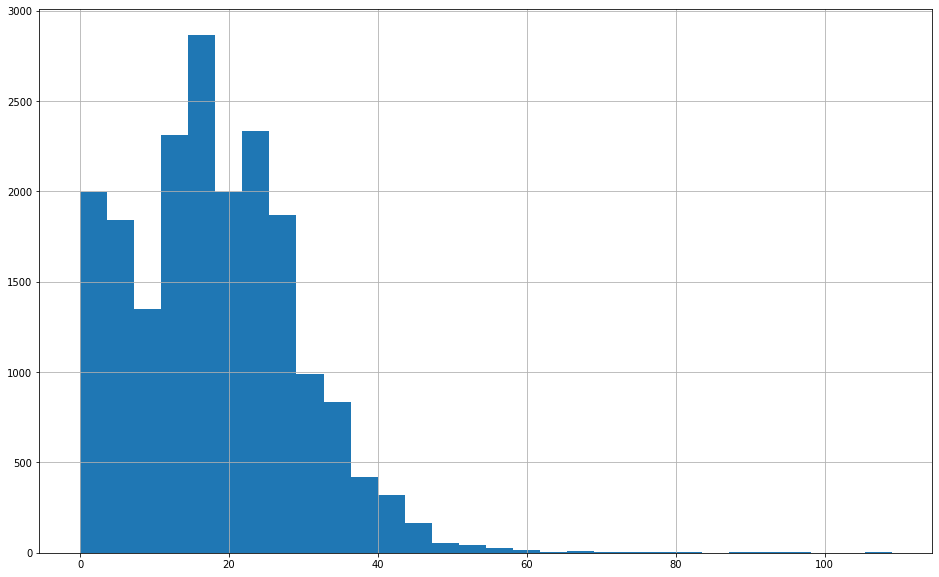

In [23]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['Text']]
pd.Series(seq_len).hist(bins = 30)

### Define Model Architecture

In [24]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
class About_Arch(nn.Module):
    def __init__(self, dropout_rate=0.1, hidden_features=512):
        super(About_Arch, self).__init__()

        # Instantiate BERT model
        self.bert = bert

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(768, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, 2),
        )

        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)        
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        x = self.classifier(last_hidden_state_cls)
        
        x = self.softmax(x)

        return x

In [46]:
class AboutClassifier(BaseEstimator):    
    
    def __init__(self,
                 epochs = 10,
                 batch_size = 32,
                 lr = 0.0009759263496774533,
                 max_length = 40,
                 dropout_rate = 0.12200844146290686, 
                 hidden_features = 512,
                ):
            self.epochs = epochs
            self.batch_size = batch_size
            self.lr = lr
            self.max_length = max_length
            
            self.dropout_rate = dropout_rate
            self.hidden_features = hidden_features
            
            self.device = torch.device('cuda')                    

    def fit(self, X, y, sample_weight):  
        # Tokenize and encode sequences in the training set
        tokens_train = tokenizer.batch_encode_plus(
            X['Text'].tolist(),
            max_length = self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False
        )
        
        # Convert integer sequences to tensors
        train_seq = torch.tensor(tokens_train['input_ids'])
        train_mask = torch.tensor(tokens_train['attention_mask'])
        train_y = torch.tensor(y.tolist())
        train_w = torch.tensor(sample_weight.tolist())

        # Create dataloader        
        train_data = TensorDataset(train_seq, train_mask, train_y, train_w)
        train_dataloader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data),
                                      batch_size=self.batch_size)
        
        # Freeze BERT the parameters
        for param in bert.parameters():
            param.requires_grad = False

        self.model = About_Arch(dropout_rate=self.dropout_rate, hidden_features=self.hidden_features)
        self.model.to(self.device, non_blocking=True)
            
        parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        
        optimizer = torch_optim.Adam(parameters, lr=self.lr)
        criterion = nn.CrossEntropyLoss().to(self.device)
        
        self.model.train()

        # Train net
        for epoch in range(self.epochs):
            for sent_id, mask, train_y, train_w in train_dataloader:
                
                sent_id = sent_id.to(self.device, non_blocking=True)
                mask = mask.to(self.device, non_blocking=True)                
                train_y = train_y.to(self.device, non_blocking=True)
                train_w = train_w.to(self.device, non_blocking=True)
                
                optimizer.zero_grad()
                
                yhat = self.model(sent_id, mask)    
                loss = criterion(yhat, train_y)
                loss = (loss * train_w / train_w.sum()).sum()

                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 1.0) # Tanh :(
                optimizer.step()
        return self
        
    def predict_proba(self, X):
        self.model.eval()
        
        batch_size = 512
        
        step = math.ceil(X.shape[0]/batch_size)
        yhat_all = None
        
        for i in range(step):
            # Tokenize and encode sequences in the training set
            tokens_test = tokenizer.batch_encode_plus(
                X['Text'][i*batch_size:i*batch_size+batch_size].tolist(),
                max_length = self.max_length,
                padding='max_length',
                truncation=True,
                return_token_type_ids=False
            )

            # Convert integer sequences to tensors
            sent_id = torch.tensor(tokens_test['input_ids'])
            mask = torch.tensor(tokens_test['attention_mask'])

            self.model.to(self.device, non_blocking=True)
            sent_id = sent_id.to(self.device, non_blocking=True)
            mask = mask.to(self.device, non_blocking=True)

            yhat = self.model(sent_id, mask)
            yhat = F.softmax(yhat, dim=1)
            yhat = torch.clamp(yhat, 0, 1)

            yhat = yhat.cpu().detach().numpy()

            if yhat_all is None:
                yhat_all = yhat
            else:
                yhat_all = np.concatenate([yhat_all, yhat])

        return yhat_all

    def predict(self, X):
        yhat = self.predict_proba(X)[:, 1]
        return yhat.round().astype(np.int32)    

### Outliers detection

In [27]:
aug_mask = (X['is_aug'] == 1)

In [28]:
#Train without aug
clf = AboutClassifier()
clf.fit(X[~aug_mask], y[~aug_mask], w[~aug_mask])

AboutClassifier()

In [29]:
#Make outliers mask
y_pred = clf.predict(X)

outliers_mask = (y != y_pred)

print (f'Outliers found: {outliers_mask[outliers_mask].count()}')

Outliers found: 2863


In [30]:
df[~outliers_mask]['Label'].value_counts(normalize = True)

0    0.536521
1    0.463479
Name: Label, dtype: float64

### Rewriting cross_val_score because sklearn cross_val_score does not support weights. + outliers_mask suppor

In [31]:
from typing import Callable
from joblib import Parallel, delayed
from sklearn.base import clone

def cross_val_score(
        clf, 
        X: pd.DataFrame,
        y: pd.Series,
        cv_gen,
        aug_mask: np.ndarray = None,
        outliers_mask: np.ndarray = None,
        sample_weight_train: np.ndarray = None,
        scoring: Callable[[np.array, np.array], float] = roc_auc_score,
        n_jobs = -1):

    # If no sample_weight then broadcast a value of 1 to all samples (full weight).
    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if aug_mask is None:
        aug_mask = np.zeros((X.shape[0],), dtype=bool)

    if outliers_mask is None:
        outliers_mask = np.zeros((X.shape[0],), dtype=bool)
        
    if isinstance(cv_gen, list): cv_gen_list = cv_gen
    else: cv_gen_list = list(cv_gen.split(X=X, y=y))      
                        
    def calc_fold(train, test):
        X_train_ = X.iloc[train, :].loc[~outliers_mask.iloc[train]]
        X_test_ = X.iloc[test, :].loc[~aug_mask.iloc[test]]

        y_train_ = y.iloc[train].loc[~outliers_mask.iloc[train]]
        y_test_ = y.iloc[test].loc[~aug_mask.iloc[test]]

        w_train_ = sample_weight_train.iloc[train].loc[~outliers_mask.iloc[train]]

        classifier = clone(clf)
        fit = classifier.fit(X = X_train_, y = y_train_, sample_weight = w_train_)

        if scoring == roc_auc_score:
            prob = fit.predict_proba(X_test_)[:, 1]
            score = scoring(y_test_, prob)
        else:
            pred = fit.predict(X_test_)
            score = scoring(y_test_, pred)

        return score
        
    # Score model on Folds
    ret_scores = Parallel(n_jobs=n_jobs)(delayed(calc_fold)(train, test) for train, test in cv_gen_list)
        
    return np.array(ret_scores)

### Search for hyperparameters, using the statistically unreliable k-fold test. (To save time)

In [32]:
def objective(trial):

    epochs = trial.suggest_int("epochs", 5, 15)
    lr = trial.suggest_float("lr", 1e-5, 1e-3)
    
    max_length = trial.suggest_int("max_length", 20, 50, 5)
    hidden_features = trial.suggest_int("hidden_features", 128, 1024, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.2)

    clf = AboutClassifier(epochs=epochs, lr=lr, max_length=max_length, 
                          hidden_features=hidden_features, dropout_rate=dropout_rate)

    cv_gen = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    cv_gen_list = list(cv_gen.split(X, y))
    
    new_score = cross_val_score(clf,
                                X=X, y=y,
                                cv_gen=cv_gen_list,
                                aug_mask=aug_mask,
                                outliers_mask=outliers_mask,
                                sample_weight_train=w,
                                scoring=f1_score,
                                n_jobs=1
                                )

    return new_score.mean()

In [50]:
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)
print ("Best score", study.best_value)
print ("Best params", study.best_params)

[I 2021-08-23 01:32:37,985] A new study created in memory with name: no-name-d067dd0e-8dd4-4cc3-959a-5a3cf595bf0e
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:46: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2021-08-23 01:47:19,745] Trial 0 finished with value: 0.5507677246116283 and parameters: {'epochs': 13, 'lr': 0.0009959726694535962, 'max_length': 35, 'hidden_features': 128, 'dropout_rate': 0.010857961442085486}. Best is trial 0 with value: 0.5507677246116283.
[I 2021-08-23 01:55:41,959] Trial 1 finished with value: 0.5059538847620154 and parameters: {'epochs': 6, 'lr': 4.5037151969729385e-05, 'max_length': 40, 'hidden_features': 640, 'dropout_rate': 0.0017668178447644456}. Best is trial 0 with value: 0.5507677246116283.
[I 2021-08-23 02:16:16,744] Trial 2 finished with value: 0.5562595901349643 and parameters: {'epochs': 15, 'lr': 0.00045154254155625794, 'max_length': 40, 'hidden_features': 256, 'dropout_rate': 0.03351596973090665}. Best is trial 2 with value: 0.5562595901349643.
[I 2021-08-23 02:25:39,530] Trial 3 finished with value: 0.5295181884495583 and parameters: {'epochs': 12, 'lr': 0.00042739706211148624, 'max_length': 20, 'hidden_features': 1024, 'dropout_rate': 0.110038

[I 2021-08-23 09:51:30,905] Trial 30 finished with value: 0.5370225080122589 and parameters: {'epochs': 14, 'lr': 0.0005035496055954715, 'max_length': 45, 'hidden_features': 256, 'dropout_rate': 0.09704194039162212}. Best is trial 22 with value: 0.5697382890885205.
[I 2021-08-23 10:12:05,932] Trial 31 finished with value: 0.5257125115779613 and parameters: {'epochs': 15, 'lr': 0.0003025618653353282, 'max_length': 40, 'hidden_features': 256, 'dropout_rate': 0.032185925105536625}. Best is trial 22 with value: 0.5697382890885205.
[I 2021-08-23 10:29:01,381] Trial 32 finished with value: 0.539220647675176 and parameters: {'epochs': 15, 'lr': 0.0005012262199993718, 'max_length': 35, 'hidden_features': 128, 'dropout_rate': 0.06991291111255704}. Best is trial 22 with value: 0.5697382890885205.
[I 2021-08-23 10:36:02,147] Trial 33 finished with value: 0.5000250651846818 and parameters: {'epochs': 5, 'lr': 0.00015006356190988074, 'max_length': 40, 'hidden_features': 256, 'dropout_rate': 0.05065

In [ ]:
# Best score 0.5697382890885205
# Best params {'epochs': 15, 'lr': 0.0005635251197947561, 'max_length': 30, 'hidden_features': 256, 'dropout_rate': 0.052866853804976924}

### Test on test data

In [51]:
clf = AboutClassifier(epochs=study.best_params['epochs'], lr=study.best_params['lr'], 
                      max_length=study.best_params['max_length'], 
                      hidden_features=study.best_params['hidden_features'], 
                      dropout_rate=study.best_params['dropout_rate'])

In [52]:
%%time
clf.fit(X[~outliers_mask], y[~outliers_mask], w[~outliers_mask])

CPU times: user 3min 18s, sys: 33.4 s, total: 3min 51s
Wall time: 3min 50s


AboutClassifier(dropout_rate=0.052866853804976924, epochs=15,
                hidden_features=256, lr=0.0005635251197947561, max_length=30)

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      2729
           1       0.40      0.89      0.55       374

    accuracy                           0.83      3103
   macro avg       0.69      0.85      0.72      3103
weighted avg       0.91      0.83      0.85      3103

Confusion Matrix
[[2229  500]
 [  42  332]]

Roc auc score
0.8522416195233216

Target score
0.550580431177446


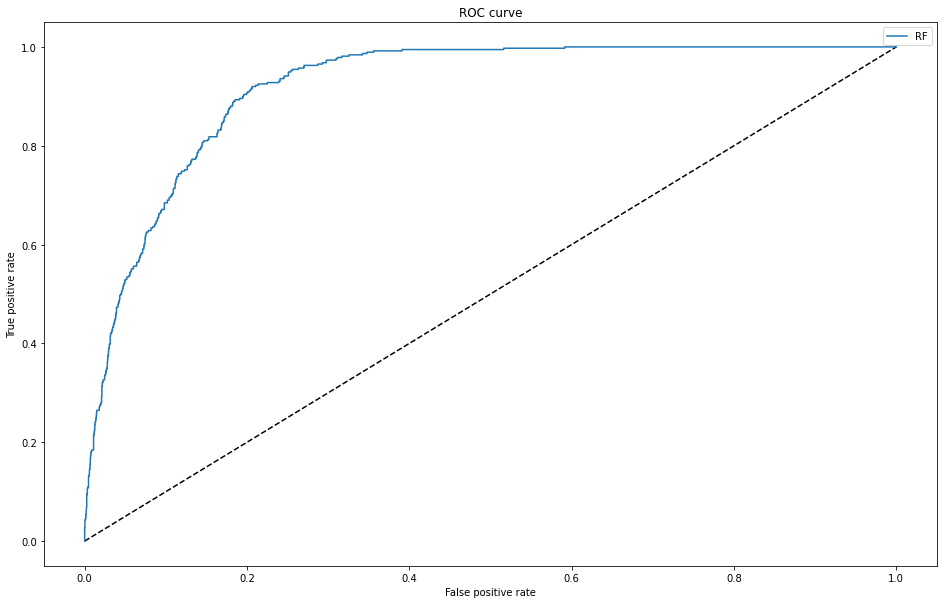

In [53]:
y_pred_rf = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Roc auc score")
print(roc_auc_score(y_test, y_pred))

print('')
print("Target score")
print(f1_score(y_test, y_pred))


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()